## Mount Google Drive

In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Get scripts

In [0]:
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/getData.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/constants.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/trainingUtils.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/models.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/analysisFunctions.py

## Get data

In [1]:
from getData import downloadSpeechData, getDataDict

# Download data
downloadSpeechData(data_path='speechData/')

# Get dict with files and labels
dataDict = getDataDict(data_path='speechData/')

Nothing to do.
Nothing to do.


In [2]:
from getData import getDataframe
import pandas as pd

trainDF = getDataframe(dataDict['train'])
valDF = getDataframe(dataDict['val'])
testDF = getDataframe(dataDict['test'], include_unknown=True) 
finalTestDF = getDataframe(dataDict['finalTest'], include_unknown=True) 

print("Train files: {}".format(trainDF.shape[0]))
print("Validation files: {}".format(valDF.shape[0]))
print("Test files: {}".format(testDF.shape[0]))
print("Final test files: {}".format(finalTestDF.shape[0]))

Train files: 51088
Validation files: 6798
Test files: 6835
Final test files: 3081


## Install tf 2.0 and python speech features

In [5]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 70kB/s 
     |████████████████████████████████| 3.1MB 28.8MB/s 
     |████████████████████████████████| 501kB 41.7MB/s 


In [3]:
import tensorflow as tf

print("GPU Available: ", tf.test.is_gpu_available())
print("Version: ", tf.__version__)

GPU Available:  True
Version:  2.0.0-beta1


In [7]:
!pip install -q python_speech_features

## Data Generators



In [0]:
from trainingUtils import getDataset

BATCH_SIZE = 32
# Reduced trainign dataset by using a numer <60k
NUM_EXAMPLES = 60000

train_data, train_steps = getDataset(
    df=trainDF[:NUM_EXAMPLES],
    batch_size=BATCH_SIZE,
    cache_file='train_cache',
    shuffle=True,
    scale=True
) 

val_data, val_steps = getDataset(
    df=valDF,
    batch_size=BATCH_SIZE,
    cache_file='val_cache',
    shuffle=False,
    scale=True
)

## Model

![InceptionBlock](https://i.stack.imgur.com/vGIfJ.png)

In [23]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Input, Reshape, BatchNormalization, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

def inceptionModule(x_input, n):
    # Conv 1x1
    conv_1x1 = Conv2D(n, (1,1), padding='same', activation='relu')(x_input)
    
    # Conv 3x3
    conv_3x3 = Conv2D(n, (1,1), padding='same', activation='relu')(x_input)
    conv_3x3 = Conv2D(n, (3,3), padding='same', activation='relu')(conv_3x3)
    
    # Conv 5x5
    conv_5x5 = Conv2D(n, (1,1), padding='same', activation='relu')(x_input)
    conv_5x5 = Conv2D(n, (3,3), padding='same', activation='relu')(conv_5x5)
    
    # pool + proj
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(x_input)
    pool = Conv2D(n, (1,1), padding='same', activation='relu')(pool)
    
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool], axis=3)
    
    return output


def Inception(input_shape=(99,40)):
    
    input_layer = Input(shape=(99, 40))
    
    reshape_layer = Reshape(input_shape=input_shape, target_shape=(99, 40, 1))(input_layer)
      
    x = Conv2D(32, (6,4), padding='same', strides=(2, 2), activation='relu')(reshape_layer)
    x = MaxPooling2D((3,2), padding='same', strides=(1, 1))(x)
    x = BatchNormalization()(x)
    
    x = inceptionModule(x, 32)
    x = inceptionModule(x, 64)
    x = MaxPooling2D((3,2))(x)
    
    x = inceptionModule(x, 64)
    x = inceptionModule(x, 128)
    
    x = GlobalAveragePooling2D()(x)   
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='relu')(x)
    
    x = Dense(30, activation='softmax')(x)
    
    model = Model(input_layer, x)
    return model

model = Inception0()
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 99, 40)]     0                                            
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 99, 40, 1)    0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 50, 20, 32)   800         reshape_8[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_38 (MaxPooling2D) (None, 50, 20, 32)   0           conv2d_171[0][0]                 
____________________________________________________________________________________________

In [0]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["sparse_categorical_accuracy"])

In [25]:
EPOCHS = 50

# Stop if the validation accuracy doesn't imporove for 7 epochs
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    patience=7,
    verbose=1
)

# Reduce LR on Plateau
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1
)

# Save best models
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    "inception.h5",
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True
)

history = model.fit(train_data.repeat(), 
          steps_per_epoch=train_steps,
          validation_data=val_data.repeat(),
          validation_steps=val_steps,
          epochs=EPOCHS,
          callbacks=[earlyStopping, reduceLR, modelCheckpoint])

Epoch 1/50
1596/1596 [==============================] - 125s 78ms/step - loss: 1.8438 - sparse_categorical_accuracy: 0.4491 - val_loss: 0.6145 - val_sparse_categorical_accuracy: 0.8188
Epoch 2/50
1596/1596 [==============================] - 121s 76ms/step - loss: 0.4728 - sparse_categorical_accuracy: 0.8594 - val_loss: 0.3812 - val_sparse_categorical_accuracy: 0.8824
Epoch 3/50
1596/1596 [==============================] - 120s 75ms/step - loss: 0.3305 - sparse_categorical_accuracy: 0.9013 - val_loss: 0.2965 - val_sparse_categorical_accuracy: 0.9105
Epoch 4/50
1596/1596 [==============================] - 120s 75ms/step - loss: 0.2712 - sparse_categorical_accuracy: 0.9193 - val_loss: 0.2506 - val_sparse_categorical_accuracy: 0.9281
Epoch 5/50
1596/1596 [==============================] - 120s 75ms/step - loss: 0.2322 - sparse_categorical_accuracy: 0.9308 - val_loss: 0.2452 - val_sparse_categorical_accuracy: 0.9254
Epoch 6/50
1596/1596 [==============================] - 120s 75ms/step - lo

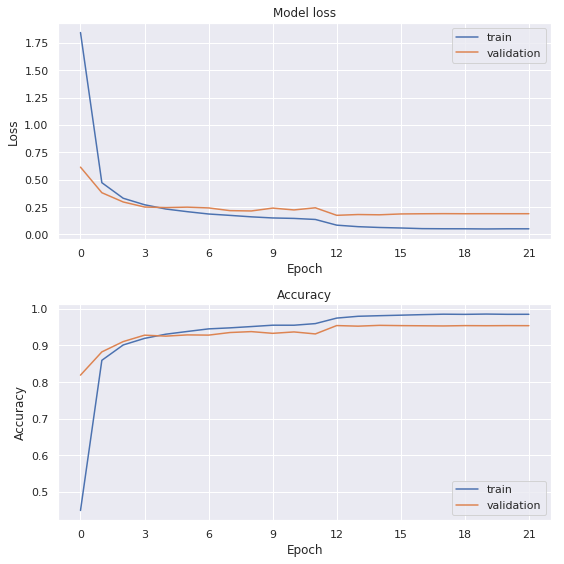

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns 

sns.set()

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

ax1.plot(loss, label='train')
ax1.plot(val_loss, label='validation')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc, label='train')
ax2.plot(val_acc, label='validation')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
fig.show()

## Save to Drive


In [28]:
import pickle

GDRIVE_PATH = "/content/gdrive/My Drive/speechRecognition/inception/"

# Save model
model.save(GDRIVE_PATH + "inception_small_954.h5")
print("Saved model to drive")

# Save history data
with open(GDRIVE_PATH + "train_history_inception_small_954.pickle", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)    
print("Saved training history to drive")

Saved model to drive
Saved training history to drive


## Extract features

In [0]:
marvin_data, _ = getDataset(
    df=trainDF.loc[trainDF['category']=='marvin', :],
    batch_size=32,
    cache_file='oc_train_cache',
    shuffle=False,
    scale=True
)

In [30]:
valDF['oc_class'] = valDF.apply(lambda row: 1 if row['category']=='marvin' else -1, axis=1)
val_true = valDF['oc_class'].tolist()
valDF.head()

,files,labels,category,oc_class
0,speechData/train/bed/026290a7_nohash_0.wav,16,bed,-1
1,speechData/train/bed/060cd039_nohash_0.wav,16,bed,-1
2,speechData/train/bed/060cd039_nohash_1.wav,16,bed,-1
3,speechData/train/bed/099d52ad_nohash_0.wav,16,bed,-1
4,speechData/train/bed/0e17f595_nohash_0.wav,16,bed,-1


In [0]:
from trainingUtils import _loadWavs, _logMelFilterbank, _normalize

def _parse_fn(filename):
    wave = _loadWavs(filename)
    fbank = _logMelFilterbank(wave)
    return _normalize(fbank)

In [0]:
def getFeatures(data):
    layer_name = 'dense_14'
    layer_out = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return layer_out.predict(data, use_multiprocessing=True)

In [0]:
import numpy as np
valData = np.zeros((valDF.shape[0], 99, 40))

for i,f in enumerate(valDF['files']):
    valData[i] = _parse_fn(f)

In [35]:
X_train = getFeatures(marvin_data)
X_val = getFeatures(valData)

W0713 16:19:58.331772 140188310996736 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0713 16:19:58.338513 140188310996736 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0713 16:19:58.339859 140188310996736 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0713 16:19:58.341178 140188310996736 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.bool
W0713 16:19:58.346040 140188319389440 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string


## PCA

In [63]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)

pca.fit(X_train)

print(sum(pca.explained_variance_ratio_)) 

0.94464156543836


In [0]:
X_train_transformed = pca.transform(X_train)
X_val_transformed = pca.transform(X_val)

## OC-SVM

In [49]:
from sklearn.metrics import f1_score
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')

gamma_bgn, gamma_end, num_gamma  = 0.00001, 0.005, 40 
nu_bgn, nu_end, num_nu  = 0.001, 0.1, 40

gamma_list = np.arange(gamma_bgn, gamma_end, (gamma_end - gamma_bgn) / num_gamma)
nu_list = np.arange(nu_bgn, nu_end, (nu_end - nu_bgn) / num_nu)

best_score_svm = 0
scores_svm = np.zeros((gamma_list.shape[0], nu_list.shape[0]))
best_parameters_svm = {'gamma':0, 'nu':0}

iterations = gamma_list.shape[0] * nu_list.shape[0]
iteration = 1

for i, gamma in enumerate(gamma_list):
    for j, nu in enumerate(nu_list):
        
        if(iteration%100==0):
            print("Iteration {}/{}".format(iteration, iterations))
            
        oc_svm = svm.OneClassSVM(gamma=gamma, nu=nu)
        ocmodel = oc_svm.fit(X_train_transformed)
   
        val_pred = oc_svm.predict(X_val_transformed)
                
        score = f1_score(val_pred, val_true)
        
        if score>best_score_svm:
            print("New best score: {:4f}".format(score))     
            best_score_svm = score
            best_parameters_svm['gamma'] = gamma
            best_parameters_svm['nu'] = nu
            
        scores_svm[i][j] = score
        iteration += 1

New best score: 0.059546
New best score: 0.061936
New best score: 0.062967
New best score: 0.109628
New best score: 0.722222
New best score: 0.854795
New best score: 0.873950
New best score: 0.914956
New best score: 0.920354
New best score: 0.931343
New best score: 0.947692
New best score: 0.959248
New best score: 0.962264
New best score: 0.964856
New best score: 0.965944
New best score: 0.968750
Iteration 100/1600
New best score: 0.971963
Iteration 200/1600
Iteration 300/1600
Iteration 400/1600
Iteration 500/1600
Iteration 600/1600
Iteration 700/1600
Iteration 800/1600
Iteration 900/1600
Iteration 1000/1600
Iteration 1100/1600
Iteration 1200/1600
Iteration 1300/1600
Iteration 1400/1600
Iteration 1500/1600
Iteration 1600/1600


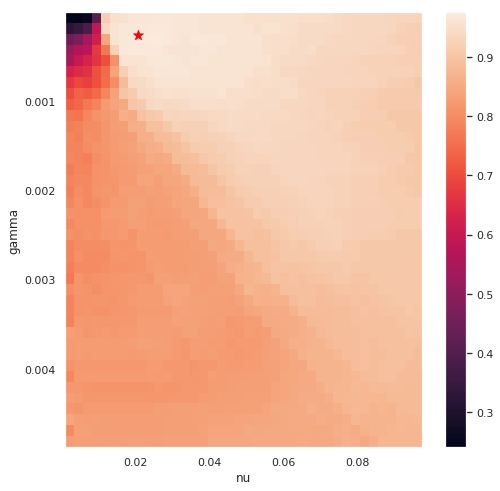

In [146]:
fig, ax = plt.subplots(figsize=(8,8))

im = ax.imshow(scores_svm, aspect="auto", extent=[nu_list[0], nu_list[-1], gamma_list[-1], gamma_list[0]])
fig.colorbar(im, orientation='vertical')

ax.set_xlabel('nu')
ax.set_ylabel('gamma')

ax.scatter(best_parameters_svm['nu'], best_parameters_svm['gamma'], c='red', s=100, marker='*')
ax.grid(False)

fig.show()

Accuracy: 0.9987
Precision: 0.9689
Recal: 0.9750
F1-score: 0.9720


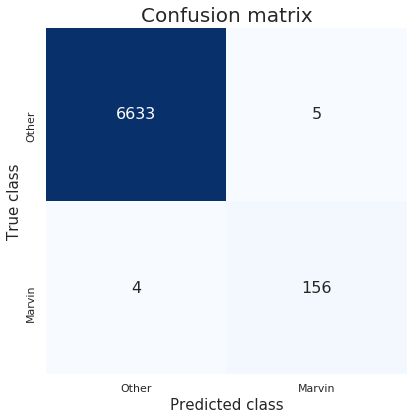

In [51]:
from analysisFunctions import showResultsOC

oc_svm = svm.OneClassSVM(gamma=best_parameters_svm['gamma'], nu=best_parameters_svm['nu'])
ocmodel = oc_svm.fit(X_train_transformed)

val_pred = oc_svm.predict(X_val_transformed)
showResultsOC(val_pred, val_true)

## Bayesian optimization fot SVM 

In [0]:
!pip install -q scikit-optimize

In [0]:
from skopt.space import Real
from skopt.utils import use_named_args

oc_svm = svm.OneClassSVM()

space  = [
    Real(10**-5, 10**0, "log-uniform", name='gamma'),
    Real(10**-5, 10**0, "log-uniform", name='nu')
]

@use_named_args(space)
def objective(**params):
    oc_svm.set_params(**params)
    
    oc_svm.fit(X_train_transformed)
    val_pred = oc_svm.predict(X_val_transformed)
    
    score = f1_score(val_pred, val_true)
   

    return -1*score

In [171]:
from skopt import gp_minimize

res_gp = gp_minimize(objective, space, n_calls=30, random_state=0, n_jobs=-1, verbose=False)

print("Best score={:.4f}".format(-res_gp.fun))

Best score=0.9716


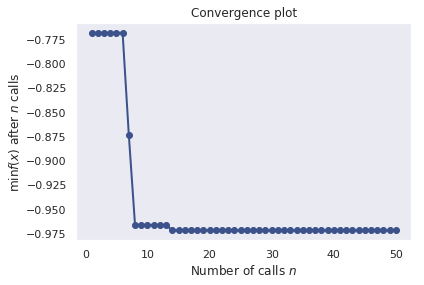

In [148]:
from skopt.plots import plot_convergence

plot_convergence(res_gp);

In [167]:
best_parameters = {k.name: x for k, x in zip(space, res_gp.x) }

best_parameters

{'gamma': 0.0005696384776551495, 'nu': 0.027147673650521304}

Accuracy: 0.9987
Precision: 0.9809
Recal: 0.9625
F1-score: 0.9716


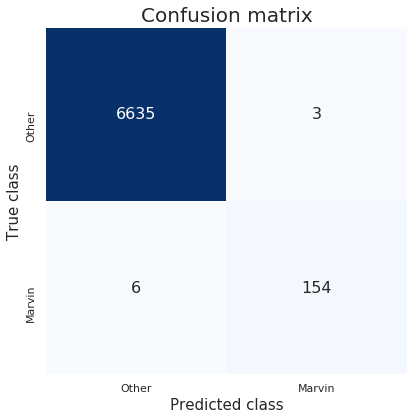

In [173]:
bestOC = svm.OneClassSVM().set_params(**best_parameters)

bestOC.fit(X_train_transformed)

val_pred = bestOC.predict(X_val_transformed)
showResultsOC(val_pred, val_true)